https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset
● Description of your dataset: resource, dimension, variable description, etc.
● Statement of the research questions, and a summary of methods being used in the analysis
● The explanatory data analysis may include but not limited to graphs, demographic summaries, crosstables, individual tests, etc.. And some initial findings at this point.
● Regression analysis that may include but not limited to multiple linear regression model and logistic regression model.

"timestamp" - timestamp field for grouping the data
"cnt" - the count of a new bike shares
"t1" - real temperature in C
"t2" - temperature in C "feels like"
"hum" - humidity in percentage
"windspeed" - wind speed in km/h
"weathercode" - category of the weather
"isholiday" - boolean field - 1 holiday / 0 non holiday   ##bealoon variable
"isweekend" - boolean field - 1 if the day is weekend     ##categorical variable
"season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.  ##categorical variable

"weathe_code" category description:
1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 2 = scattered clouds / few clouds 3 = Broken clouds 4 = Cloudy 7 = Rain/ light Rain shower/ Light rain 10 = rain with thunderstorm 26 = snowfall 94 = Freezing Fog

In [22]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

data = pd.read_csv("london_merged.csv")

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [24]:
data.shape
data.isnull().any()

timestamp       False
cnt             False
t1              False
t2              False
hum             False
wind_speed      False
weather_code    False
is_holiday      False
is_weekend      False
season          False
dtype: bool

In [25]:
data.sample(5)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
14464,2016-09-01 11:00:00,1205,21.0,21.0,57.0,15.0,1.0,0.0,0.0,2.0
6360,2015-09-27 00:00:00,745,12.0,12.0,72.0,2.0,1.0,0.0,1.0,2.0
651,2015-01-31 04:00:00,96,2.0,-2.5,81.0,18.0,3.0,0.0,1.0,3.0
6549,2015-10-04 21:00:00,578,13.0,13.0,79.5,16.0,1.0,0.0,1.0,2.0
6079,2015-09-15 06:00:00,590,12.0,12.0,77.0,21.0,7.0,0.0,0.0,2.0


In [26]:
data["timestamp"] = pd.to_datetime(data["timestamp"])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     17414 non-null  datetime64[ns]
 1   cnt           17414 non-null  int64         
 2   t1            17414 non-null  float64       
 3   t2            17414 non-null  float64       
 4   hum           17414 non-null  float64       
 5   wind_speed    17414 non-null  float64       
 6   weather_code  17414 non-null  float64       
 7   is_holiday    17414 non-null  float64       
 8   is_weekend    17414 non-null  float64       
 9   season        17414 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 1.3 MB


In [27]:
sorted(data['season'].unique()),sorted(data['weather_code'].unique())

([0.0, 1.0, 2.0, 3.0], [1.0, 2.0, 3.0, 4.0, 7.0, 10.0, 26.0])

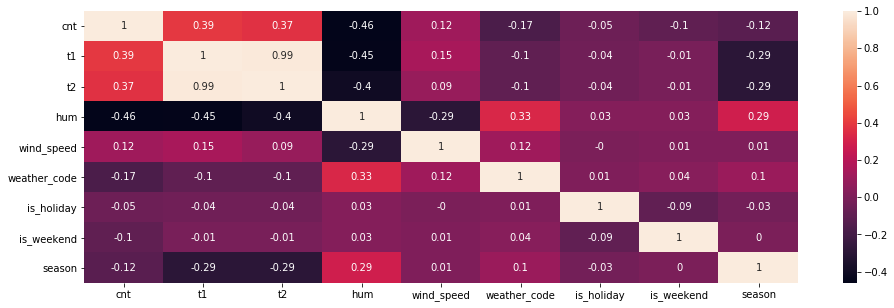

In [28]:
import seaborn as sns
correlation_matrix = data.corr().round(2)
plt.figure(figsize = (16,5))
sns.heatmap(data=correlation_matrix, annot=True)

In [44]:
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
y, X = dmatrices('cnt~t1+hum+wind_speed+C(weather_code)+C(is_holiday)+C(is_weekend)+C(season)', data=data, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

    VIF Factor                 features
0    79.139555                Intercept
1     1.338807   C(weather_code)[T.2.0]
2     1.447794   C(weather_code)[T.3.0]
3     1.231866   C(weather_code)[T.4.0]
4     1.470471   C(weather_code)[T.7.0]
5     1.003010  C(weather_code)[T.10.0]
6     1.023318  C(weather_code)[T.26.0]
7     1.027471     C(is_holiday)[T.1.0]
8     1.017796     C(is_weekend)[T.1.0]
9     2.439167         C(season)[T.1.0]
10    1.764904         C(season)[T.2.0]
11    1.670345         C(season)[T.3.0]
12    2.611878                       t1
13    1.869471                      hum
14    1.291169               wind_speed


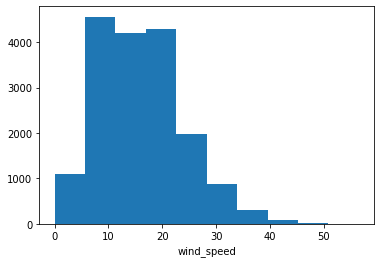

In [29]:
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(data['wind_speed'])
ax.set_xlabel("wind_speed")
plt.show()

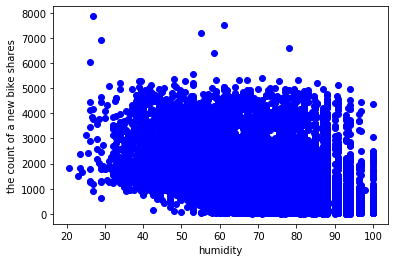

In [39]:
plt.xlabel('humidity')
plt.ylabel('the count of a new bike shares')
plt.scatter(data.hum,data.cnt,color='blue')

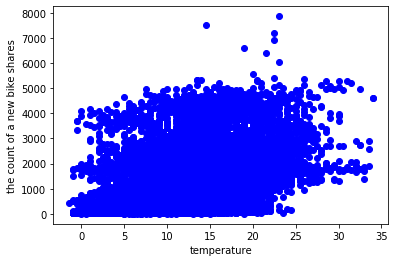

In [40]:
plt.xlabel('temperature')
plt.ylabel('the count of a new bike shares')
plt.scatter(data.t1,data.cnt,color='blue')

In [33]:
# delete the variable t2
# fit the model
model =smf.ols('cnt~t1+hum+wind_speed+C(weather_code)+C(is_holiday)+C(is_weekend)+C(season)',data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     506.6
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        19:23:51   Log-Likelihood:            -1.4345e+05
No. Observations:               17414   AIC:                         2.869e+05
Df Residuals:                   17399   BIC:                         2.870e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                2561.0622     61.680     41.522      0.000    2440.163    2681.962
C(weather_code)[T.2.0]    280.1987     19.016     14.735      0.000     242.926     317.471
C(weather_code)[T.3.0]    278.8253     20.706     13.466      0.000     238.239     319.411
C(weather_code)[T.4.0]    -97.0909     27.732     -3.501      0.000    -151.448     -42.734
C(weather_code)[T.7.0]      5.0129     25.604      0.196      0.845     -45.173      55.199
C(weather_code)[T.10.0]  -389.2944    244.998     -1.589      0.112    -869.515      90.926
C(weather_code)[T.26.0]    27.2601    119.696      0.228      0.820    -207.355     261.875
C(is_holiday)[T.1.0]     -259.2138     47.859     -5.416      0.000    -353.021    -165.406
C(is_weekend)[T.1.0]     -198.7065     15.489    -12.829      0.000    -229.066    -168.347
C(season)[T.1.0]         -123.8729     24.944     -4.966      0.000    -172.765     -74.980
C(season)[T.2.0]          113.7921     21.355      5.329      0.000      71.934     155.651
C(season)[T.3.0]          135.4103     20.732      6.532      0.000      94.774     176.047
t1                         52.8609      2.011     26.284      0.000      48.919      56.803
hum                       -28.1949      0.662    -42.568      0.000     -29.493     -26.897
wind_speed                 -7.5405      0.998     -7.556      0.000      -9.497      -5.584
==============================================================================
Omnibus:                     4812.852   Durbin-Watson:                   0.630
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12224.414
Skew:                           1.515   Prob(JB):                         0.00
Kurtosis:                       5.768   Cond. No.                     2.69e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(weather_code),6.0,1.340602e+09,2.234336e+08,266.901330,0.000000e+00
C(is_holiday),1.0,4.670732e+07,4.670732e+07,55.793956,8.428578e-14
C(is_weekend),1.0,1.440971e+08,1.440971e+08,172.130387,3.887741e-39
C(season),3.0,6.951784e+08,2.317261e+08,276.807075,1.582626e-175
t1,1.0,2.168369e+09,2.168369e+09,2590.212815,0.000000e+00
hum,1.0,1.494968e+09,1.494968e+09,1785.805003,0.000000e+00
wind_speed,1.0,4.779105e+07,4.779105e+07,57.088521,4.372701e-14
Residual,17399.0,1.456539e+10,8.371395e+05,NaN,NaN


In [46]:
sm.stats.anova_lm(model, typ=3)

,sum_sq,df,F,PR(>F)
Intercept,1.443262e+09,1.0,1724.040153,0.000000e+00
C(weather_code),3.656272e+08,6.0,72.792963,4.898383e-90
C(is_holiday),2.455807e+07,1.0,29.335699,6.167170e-08
C(is_weekend),1.377785e+08,1.0,164.582447,1.669304e-37
C(season),1.209438e+08,3.0,48.157573,5.504405e-31
t1,5.783403e+08,1.0,690.852925,2.371478e-149
hum,1.516944e+09,1.0,1812.056539,0.000000e+00
wind_speed,4.779105e+07,1.0,57.088521,4.372701e-14
Residual,1.456539e+10,17399.0,NaN,NaN
